Rebuilding the Dupuis+ spot model

In [6]:
import numpy as np
import matplotlib.pyplot as plt
import astropy.io.fits as fits
import os
import glob
from astropy.table import Table
from astropy.io import ascii
import astropy.units as u
import astropy.constants as const
from astropy.modeling import models, fitting
import lightkurve as lk
import matplotlib.gridspec as gridspec

#matplotlib set up
%matplotlib inline
from matplotlib import rcParams
rcParams["figure.figsize"] = (14, 5)
rcParams["font.size"] = 20

In [7]:
def spot(phi, gamma, U =2.784, kw=0.):
    eps0, reg, d = coverage(phi, gamma) 
    c = U*(1-(1-kw)*eps0)
    return c, eps0, reg, d

def coverage(phi, gamma):
    k = np.sin(gamma)
    z0 = get_z0(phi)
    d = ((1-k**2)*(1-z0**2))**0.5 
    if  d <= (1 - k**2) and gamma >=np.pi/2:
        eps = 1.0
        reg= 1
    elif  d <= (1 - k**2):
        reg= 2
        eps = (k**2)*z0
    elif  d > (1 - k**2):
        reg= 3
        s = (1 - k**2)/d 
        v = (d - s) / (k*z0)
        eps = (1/np.pi) *( np.arccos(s) - (s*(1-s**2)**0.5) + ( (k**2) * z0*(np.arccos(v) - (v*(1-v**2)**0.5))))
        
    if eps < 0:
        eps = 0 #hack? I guess? It fixes it?
        
    return eps, reg, d

def get_z0(phi, beta = 43.193*np.pi/180, i =np.pi/2, lam=np.pi):
    z0 = np.cos(lam - phi) * np.cos(beta) * np.sin(i) + np.sin(beta) * np.cos(i)
    return z0



2.784
2.0982292833105083


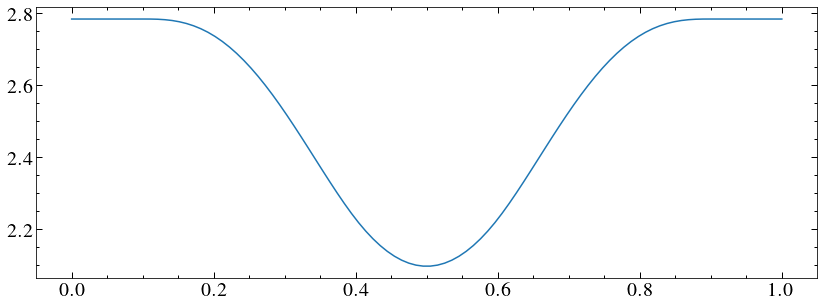

In [8]:
phi = np.linspace(0, 360, 100)
#ds = [np.tan((1-p)*np.pi) for p in phi]
gamma = 35.55*np.pi/180
counts = np.array([spot(p*np.pi/180, gamma) for p in phi])
plt.plot(phi/360, counts[:,0])
#plt.plot(phi, counts[:,1])
#plt.plot(phi, counts[:,2])
#plt.plot(phi, counts[:,3])
#plt.axhline(2.78)
#plt.axvline(90)
#plt.axvline(270)
print(max(counts[:,0]))
print(min(counts[:,0]))

In [9]:
savdat = Table([phi/360, counts[:,0]],names=['PHASE', 'COUNTS'])
ascii.write(savdat, 'spot_model.ecsv', format='ecsv', overwrite=True)

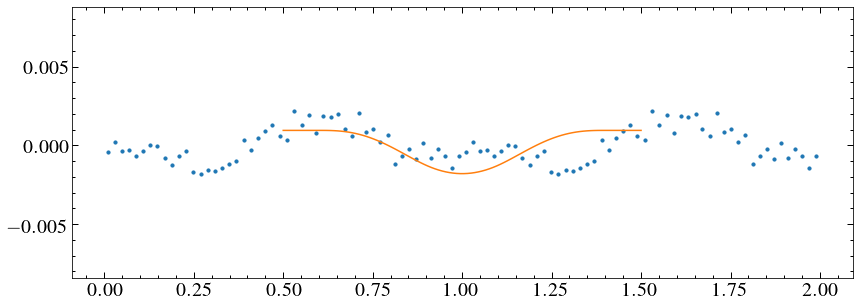

In [40]:
data = fits.getdata('folded_joint_lc.fits', 1)
t, f, e = data['TIME'], data['FLUX'], data['FLUX_ERR']
lc_fold = lk.LightCurve(time=t, flux=f, flux_err=e ).remove_outliers(sigma=5)

pbin =int(len(lc_fold.time)/50)

#plt.ylim(-0.009, 0.009)
plt.scatter(lc_fold.bin(pbin).time+0.5, lc_fold.bin(pbin).flux, s=10, c='C0')
plt.scatter(lc_fold.bin(pbin).time+1.5, lc_fold.bin(pbin).flux, s=10, c='C0')

fl = lc_fold.bin(pbin).flux
phase, mod = phi/360, counts[:,0]
#scale = (max(mod)/min(mod)) * abs((max(fl)/min(fl)))
plt.plot(phase+0.5, (mod-np.mean(mod))/250, c='C1')

In [11]:
25/0.1

250.0

Compare with actual EUVE data?

In [16]:
et, ef, ee = np.loadtxt('euve_lc/ds_5760_ltc_obs2.ascii', unpack=True)

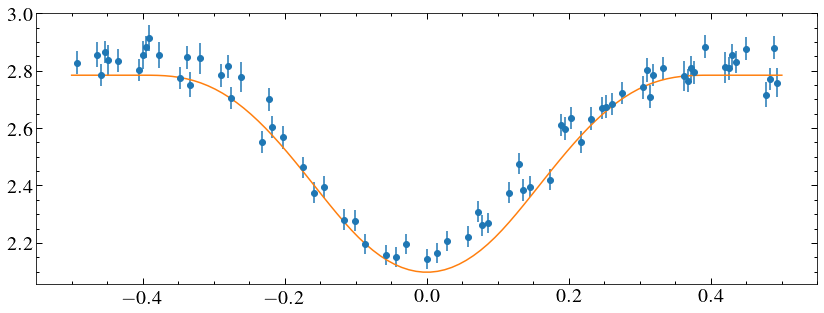

In [29]:
euve_lc = lk.LightCurve(time=et/86400, flux=ef, flux_err=ee)
#plt.errorbar(euve_lc.time, euve_lc.flux, yerr=euve_lc.flux_err, marker='o', ls='none')
t0 = euve_lc.time[np.where(ef == np.min(ef))[0][0]]
efold = euve_lc.fold(1.15, t0 = t0)
plt.errorbar(efold.time, efold.flux, yerr=efold.flux_err, marker='o', ls='none')
plt.plot(phase-0.5, mod, c='C1')

693


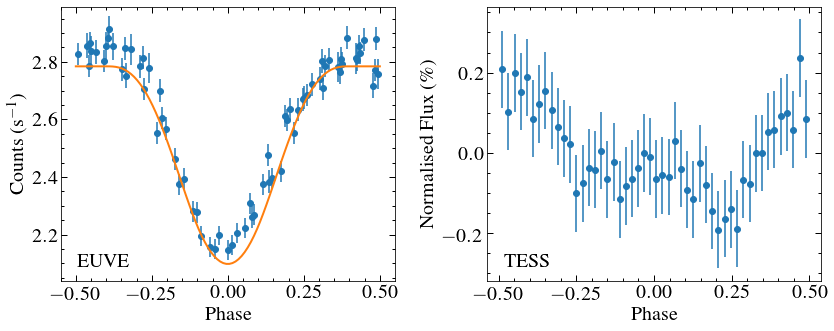

In [87]:
#eph = 2458737.560(0.018)

plt.figure(figsize=(12,5))

plt.subplot(121)
t0 = euve_lc.time[np.where(ef == np.min(ef))[0][0]]
efold = euve_lc.fold(1.15, t0 = t0)
plt.errorbar(efold.time, efold.flux, yerr=efold.flux_err, marker='o', ls='none')
plt.plot(phase-0.5, mod, c='C1', lw=2, zorder=10)
plt.xlabel('Phase')
plt.ylabel('Counts (s$^{-1}$)')
plt.annotate('EUVE', (0.05,0.05), xycoords='axes fraction' )
plt.ylim(2.04, 2.99)

plt.subplot(122)
data = fits.getdata('joint_lc.fits', 1)
t, f, e = data['TIME'], data['FLUX'], data['FLUX_ERR']
lc = lk.LightCurve(time=t, flux=f, flux_err=e ).remove_outliers(sigma=5)
print(pbin)
lc_fold2 = lc.fold(1.1468, t0 =2458737.560 ).bin(pbin)
plt.errorbar(lc_fold2.time, lc_fold2.flux*100, yerr=lc_fold2.flux_err*100, marker='o', ls='none')
plt.xlabel('Phase')
plt.ylabel('Normalised Flux (\%)')
plt.annotate('TESS', (0.05,0.05), xycoords='axes fraction' )

plt.tight_layout()
plt.savefig('plots/euve_v_tess.pdf', dpi=150)

#plt.scatter(lc_fold.bin(pbin).time, lc_fold.bin(pbin).flux, s=10, c='C1')